In [40]:
import h5py
import torch
from torch.nn import functional as F
import flow_vis
import numpy as np

from matplotlib import pyplot as plt
import cv2
from torchvision.transforms import Resize
from pytlsd import lsd

from gluefactory.utils.experiments import load_experiment
from gluefactory.models.extractors.jpldd.joint_point_line_extractor import JointPointLineDetectorDescriptor

import sys
import os

from pathlib import Path

from gluefactory.models.extractors.jpldd.line_detection_jpldd import detect_jpldd_lines as djl
from gluefactory.models.extractors.jpldd.line_utils import merge_lines

In [2]:
# Note: this only works with the way I have setup my folders and may need to be adapted
GT_FOLDER = Path().resolve().parent / "data/outputs/results"
MINI_DEPTH_FOLDER = Path().resolve().parent / "data/minidepth"

In [3]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

In [158]:
model_conf = {
    "name": "jpldd.joint_point_line_extractor",
    #"model_name": "aliked-n16",
    "max_num_keypoints": 1000,  # setting for training, for eval: -1
    #"pretrained": True,
    "timeit": True,  # override timeit: False from BaseModel
    #"train_descriptors": {
    #    "do": False,  # if train is True, initialize ALIKED Light model form OTF Descriptor GT
    #    "device": None # device to house the lightweight ALIKED model
    #},
    "line_df_decoder_channels": 32,
    "line_af_decoder_channels": 32,
    "line_detection": {
        "do": False
    },
    "checkpoint": None
}
jpldd_model = load_experiment("rk_jpldd_10/",model_conf)
#jpldd_model = JointPointLineDetectorDescriptor({})

[06/12/2024 22:55:03 gluefactory.utils.experiments INFO] Loading checkpoint checkpoint_best.tar
Load pretrained weights for aliked parts...
Load ALiked Lightweight model for descriptor training...
[06/12/2024 22:55:03 gluefactory.utils.experiments WARNING] Missing 48 parameters in aliked_lw


In [44]:
def get_prediction(img: np.ndarray) -> dict:
    img_torch = numpy_image_to_torch(img).unsqueeze(0)
    with torch.no_grad():
        output = jpldd_model({"image": img_torch})
    return output

In [7]:
name = '255027795_2652471757_o'
# name = '17450068_dc7884b082_o'
name = '562094050_5938f37ea5_o'
name = '00080'

In [45]:
def get_img(scene_name: str, img_name: str, size:tuple[int,int] = (800,800)) -> np.ndarray:
    image_path = MINI_DEPTH_FOLDER / "images" / scene_name / img_name
    img = cv2.resize(cv2.imread(str(image_path)),size)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return rgb_img

## GT data

In [46]:
def get_gt_data(scene_name: str, img_name: str) -> tuple[np.ndarray,np.ndarray,np.ndarray]:
    with h5py.File(GT_FOLDER / "deeplsd_gt" / scene_name / img_name, 'r') as f:
        dl_angle_field = np.array(f['deeplsd_angle_field'])
        dl_distance_field = np.array(f['deeplsd_distance_field'])
    with h5py.File(GT_FOLDER / "superpoint_gt" / scene_name / img_name, 'r') as f:
        sp_heatmap = np.array(f['superpoint_heatmap'])
    return dl_angle_field,dl_distance_field,sp_heatmap

In [67]:
#af,df,hm = get_gt_data("0005","562094050_5938f37ea5_o.hdf5")
img = get_img("0060","33842854_19e955c081_o.jpg")

In [159]:
img_output = get_prediction(img)

In [160]:
af = img_output["line_anglefield"][0]
df = img_output["line_distancefield"][0]
kp = img_output["keypoints"][0]

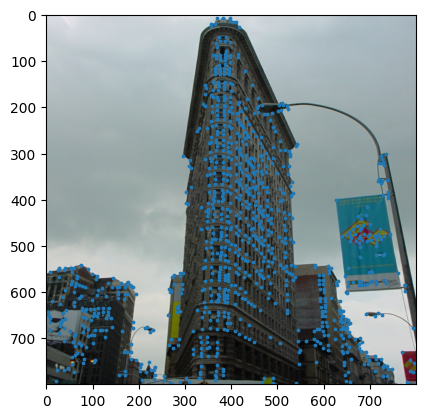

In [161]:
jpldd_keypoints = kp.T
plt.imshow(img)
plt.scatter(jpldd_keypoints[0],jpldd_keypoints[1],s=3,label="JPLDD")
plt.show()

In [25]:
jpldd_keypoints.shape

torch.Size([2, 1000])

## Detection

In [133]:
def fine_line_filter(
    lines, points,angles,direction, df_thresh=5, 
    inlier_thresh=0.7, a_diff_thresh=np.pi/20,a_std_thresh=np.pi/30,
    a_inlier_thresh=0.5,merge=False,merge_thresh=4
):
    '''
    lines: (N, 2, 2) -> each of the N elements: [[x1, x2], [y1, y2]]
    '''

    # each point with distance field lower than threshold is an inlier
    inlier_indices = points < df_thresh
    inlier_ratio = inlier_indices.sum(dim=-1).float() / inlier_indices.shape[-1]
    
    # same thing just with angles
    valid_angles = angles
    inlier_angle_indices = torch.remainder(torch.abs(valid_angles[0] - direction.unsqueeze(-1)), np.pi).unsqueeze(0) < a_diff_thresh
    angle_inlier_ratio = inlier_angle_indices.sum(dim=-1).float() / inlier_angle_indices.shape[-1]
    
    # Most time is spent on finding local minimum. The higher the ratio is the more points it should take into consideration
    # The higher the sample rate, the longer it takes

    crit1 = points.mean(dim=-1) < df_thresh
    crit2 = valid_angles.std(dim=-1) < a_std_thresh
    crit3 = inlier_ratio > inlier_thresh
    crit4 = torch.remainder(torch.abs(valid_angles.mean(dim=-1) - direction), np.pi) < a_diff_thresh
    crit5 = angle_inlier_ratio > a_inlier_thresh

    validity = crit1 & crit2 & crit3 & crit4 & crit5
    lines = lines.unsqueeze(0)[validity]
    
    if merge:
        new_lines = lines.mT
        merged_lines = merge_lines(new_lines, thresh=merge_thresh, overlap_thresh=0.).float()
        lines = merged_lines.mT

    return lines



In [134]:
def create_line_candidates(keypoints: torch.Tensor) -> torch.Tensor:
    junctions = torch.zeros_like(keypoints).to(keypoints.device)
    junctions[:, 0], junctions[:, 1] = keypoints[:, 1].clone(), keypoints[:, 0].clone()
    lines = torch.hstack([
        torch.cartesian_prod(junctions[:, 0], junctions[:, 0]),
        torch.cartesian_prod(junctions[:, 1], junctions[:, 1]),
    ]).reshape((-1, 2, 2))
    return lines

In [135]:
def coarse_line_filter(
    lines, df,af,n_samples=10, df_thresh=5,
    a_diff_thresh=np.pi/20,a_std_thresh=np.pi/30,
    a_inlier_thresh=0.5,min_len=5,max_len=50
):
    '''
    lines: (N, 2, 2) -> each of the N elements: [[x1, x2], [y1, y2]]
    '''

    sq_line_len = (lines[:, 0, 0] - lines[:, 0, 1])**2 + (lines[:, 1, 0] - lines[:, 1, 1])**2
    # It seems like this criterion is not needed because in these cases the line length would be 0 anyway
    #validity = (lines[:, 0, 0] != lines[:, 0, 1]) & (lines[:, 1, 0] != lines[:, 1, 1])
    validity = (sq_line_len >= (min_len ** 2)) & (sq_line_len <= (max_len ** 2))
    lines = lines[validity]

    offsets = torch.linspace(0, 1, n_samples).view(1, 1, -1).to(lines.device)

    # (n_points,n_samples) for x and y respectively
    xs = lines[:, 0, :1] + (lines[:, 0, 1:] - lines[:, 0, :1]) * offsets
    xs = torch.round(xs).long()
    ys = lines[:, 1, :1] + (lines[:, 1, 1:] - lines[:, 1, :1]) * offsets
    ys = torch.round(ys).long()
    
    # Move sample points to respective point in grid with lowest line distance field value
    points = df[xs, ys]
    angles = af[xs, ys]

    # Get line direction
    slope = (lines[:, 0, 1] - lines[:, 0, 0]) / (lines[:, 1, 1] - lines[:, 1, 0] + 1e-10)
    direction = torch.remainder(torch.atan(slope), torch.pi)

    # each point with distance field lower than threshold is an inlier
    
    # same thing just with angles
    valid_angles = angles
    inlier_angle_indices = torch.remainder(torch.abs(valid_angles[0] - direction.unsqueeze(-1)), np.pi).unsqueeze(0) < a_diff_thresh
    angle_inlier_ratio = inlier_angle_indices.sum(dim=-1).float() / inlier_angle_indices.shape[-1]
    
    # Most time is spent on finding local minimum. The higher the ratio is the more points it should take into consideration
    # The higher the sample rate, the longer it takes

    crit1 = points.mean(dim=-1) < df_thresh
    crit2 = valid_angles.std(dim=-1) < a_std_thresh
    #crit3 = inlier_ratio > inlier_thresh
    crit4 = torch.remainder(torch.abs(valid_angles.mean(dim=-1) - direction), np.pi) < a_diff_thresh
    crit5 = angle_inlier_ratio > a_inlier_thresh

    validity = crit1 & crit2 & crit4 & crit5 
    lines = lines.unsqueeze(0)[validity]
    points = points[validity].unsqueeze(0)
    angles = angles[validity].unsqueeze(0)
    direction = direction.unsqueeze(0)[validity]
    return lines,points,angles,direction

In [167]:
def detect_jpldd_lines(
    df: np.array, af: np.array, keypoints: np.array,n_samples=10, df_thresh=2, 
    inlier_thresh=0.7, a_diff_thresh=np.pi/20,a_std_thresh=np.pi/30,a_inlier_thresh=0.5,
    min_len=10,merge=False,merge_thresh=4
):
    line_candidates = create_line_candidates(keypoints)
    print("Num initial candidates: ",len(line_candidates))
    prelim_valid_lines,points,angles,direction = coarse_line_filter(
        line_candidates,df,af,n_samples=n_samples,df_thresh=df_thresh + 0.5,a_diff_thresh=a_diff_thresh * 2,
        a_std_thresh=a_std_thresh * 3,a_inlier_thresh=a_inlier_thresh / 3,min_len=min_len,max_len=150
    )
    print("Num 1st filter: ", len(prelim_valid_lines))
    valid_lines = fine_line_filter(
        prelim_valid_lines, points, angles,direction,df_thresh=df_thresh,inlier_thresh=inlier_thresh,a_diff_thresh=a_diff_thresh,
        a_std_thresh=a_std_thresh,a_inlier_thresh=a_inlier_thresh,
        merge=merge,merge_thresh=merge_thresh
    )
    print("Num 2nd filter: ", len(valid_lines))

    return valid_lines

In [168]:
line_segs = detect_jpldd_lines(df,af,kp,n_samples=10, 
                    df_thresh=2, 
                    inlier_thresh=0.9,
                    a_diff_thresh=np.pi/20,
                    a_std_thresh=np.pi/10,
                    a_inlier_thresh=0.5,
                    merge=False,
                    merge_thresh=3)

Num initial candidates:  1000000
Point shape is  torch.Size([1, 25494, 10])
Angle shape is  torch.Size([1, 25494, 10])
Direction shape is  torch.Size([25494])
Num 1st filter:  25494
Num 2nd filter:  572


In [147]:
line_segs2 = djl(df,af,kp)

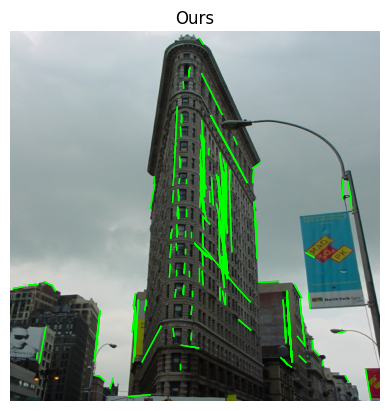

In [169]:
LINE_COLOR = 'lime'
KP_COLOR = 'r'
ALL_KP_COLOR = 'blue'

plt.title('Ours')
plt.axis('off')
# plt.imshow(npdf)
plt.imshow(img)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.imshow(np.zeros_like(img), alpha=0.25)
valid_xs = line_segs[:, 0]
valid_ys = line_segs[:, 1]
for i in range(len(line_segs)):
    x1, x2 = valid_xs[i]
    y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c=LINE_COLOR, linewidth=1)
plt.show()

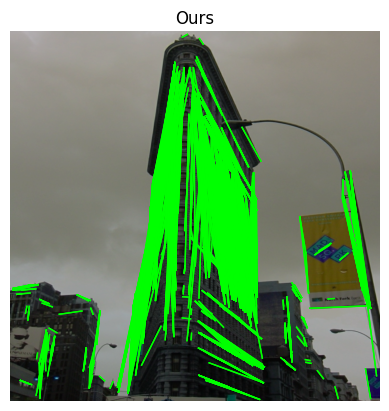

In [74]:
LINE_COLOR = 'lime'
KP_COLOR = 'r'
ALL_KP_COLOR = 'blue'

plt.title('Ours')
plt.axis('off')
# plt.imshow(npdf)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(np.zeros_like(img), alpha=0.25)
valid_xs = line_segs2[:, 0]
valid_ys = line_segs2[:, 1]
for i in range(len(line_segs2)):
    x1, x2 = valid_xs[i]
    y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c=LINE_COLOR, linewidth=1)
plt.show()